# *Introduction*

## Danh sách các thành viên:
    - Nguyễn Gia Hân - 19127134 
    - Nguyễn Khắc Vỹ - 19127637 
    - Ngô Đăng Khoa - 19127444 
    - Huỳnh Cao Nhật Hiếu - 19127399 
## Phân công công việc:
    - API:
        + Nguyễn Khắc Vỹ: Xử lí id của playlists và id của những tracks nằm trong playlists do SoundCloud tạo, viết report.
        + Nguyễn Gia Hân: Xử lí id của tracks trong playlist do users tạo, id của users, và thu thập dữ liệu bằng API.
    - HTML:
        + Ngô Đăng Khoa: Xử lí playlists vs tracks, định dạng lại các cell theo hàm.
        + Huỳnh Cao Nhật Hiếu: Lấy users, xử lí features trong user và viết report.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

# *LIBRARY*
Những thư viện đã dùng trong project này.

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import pandas as pd

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

# *Function*

## Hàm Crawl_data_from_discover
- Hàm này sẽ đưa ta đến trang discover của SoundCloud để có thể thu thập các link playlist có ở trang này. 
- Hàm nhận vào một **class webdriver** của Selenium và return ra một **list gồm tất cả các link** đã thu thập được.
- Đầu tiên driver sẽ get đến trang https://soundcloud.com/discover rồi sau đó thu thập các nút bấm **forward** để có thể load hết các playlist trên một thanh hiển thị và thu thập page source.
- Cuối cùng sử dụng **Beautiful Soup** để thu thập các href từ tag a.

In [ ]:
def Crawl_data_from_discover(driver):
    href = []
    driver.get('https://soundcloud.com/discover')
    buttons = driver.find_elements_by_class_name('tileGallery__sliderButton')
    for button in buttons:# Use forward button to load all playlist
        if button.text == 'forward':
            while True:
                try:
                    button.click()
                except:
                    break
    content = driver.page_source
    soup = BeautifulSoup(content, 'html.parser')
    Title = soup.find_all("a", class_="playableTile__heading")
    for bg in set(Title):
        href.append('https://soundcloud.com' + bg.attrs['href'])
    return list(set(href))

## Hàm scroll_webpage
- Dùng để page down một webpage để có thể load được hết page source
- Hàm nhận vào một **class webdriver** của Selenium và **một biến float để làm thời gian dừng để scroll một page**, mặc định biến này = 1
- Đầu tiên sử dụng method execute một câu lệnh script của Selenium để lấy độ cao của webpage và scroll đến cuối page.

In [ ]:
'''Reference: 
https://medium.com/analytics-vidhya/using-python-and-selenium-to-scrape-infinite-scroll-web-pages-825d12c24ec7'''
def scroll_webpage(driver, SCROLL_PAUSE_TIME = 1):
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1
    while True:
        # scroll one screen height each time
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i)) 
        time.sleep(SCROLL_PAUSE_TIME) 
        i += 1
        # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
        scroll_height = driver.execute_script("return document.body.scrollHeight;")  
        # Break the loop when the height we need to scroll to is larger than the total scroll height
        if (screen_height) * i > scroll_height:
            break 
    

## Hàm crawl_playlist_data
- Dùng để crawl thông tin của một playlist như IDs, số lượng track, người tạo,...
- Hàm nhận vào **một string là đường dẫn đến playlist cần crawl**, **một webdriver của Selenium** và trả về **dictionary chứa thông tin của track** cùng với các **list** chứa đường dẫn của các **track**, **user** bên trong playlist 
- Hàm lấy data của playlist bằng cách sử dụng một đoạn script để return ra một mảng có tên là **window.__sc_hydration** tìm thấy được các tag script của page source và trong đó chứa mọi thông tin cần thiết của playlist như **Playlist ID**, **title**, **User tạo** và các **ID của track**,...
- Chưa dừng lại ở đó, chúng ta cũng sẽ scroll hết webpage và lấy source của playlist đó để lấy các đường dẫn của **track** và **user** để tiếp tục crawl tiếp chúng ở các hàm sau.


In [ ]:
def crawl_playlist_data(url, driver):
    '''Return a playlist dictionary, links of tracks and users'''
    tracks_url = []
    users_url = []
    
    driver.get(url)
    scroll_webpage(driver)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    data = driver.execute_script('return window.__sc_hydration')[-1]['data']
    tracks_id = data['tracks']
    trackIds_string = ''
    track_content = soup.find_all(class_='trackItem__content')
    
    for item, content in zip(tracks_id, track_content):
        trackIds_string += str(item.get('id')) + ' '
        user_tag = content.find("a", class_="trackItem__username")
        try:
            user_url = "https://soundcloud.com" + user_tag.attrs['href']
        except:
            user_url = data['user'].get('permalink_url')
        track_tag = content.find("a", class_="trackItem__trackTitle")
        track_url = "https://soundcloud.com" + track_tag.attrs['href']
        tracks_url.append(track_url)
        users_url.append(user_url)
        
    playlist = {'Playlist ID': str(data.get('id')), 'Tilte': data.get('title'),'Playlist url': url, 'Genre': data.get('genre'), 'Likes count': data.get('likes_count'), 'Repost count': data.get('reposts_count'),
                'Track Count': len(tracks_url), 'TrackIDs': trackIds_string, 'Creator ID': data['user'].get('id'), 'Creator name': data['user'].get('username'), 'user url': data['user'].get('permalink_url') }
    
    return playlist, list(set(tracks_url)), list(set(users_url))

## Hàm crawl_track_data
- Dùng để crawl thông tin của một Track như IDs, Genre, lượt likes, repposts, người tạo,...
- Hàm nhận vào **một string là đường dẫn đến track cần crawl**, **một webdriver của Selenium** và trả về **dictionary chứa thông tin của track**. 
- Hàm lấy data của track bằng cách sử dụng một đoạn script để return ra một mảng có tên là **window.__sc_hydration** tìm thấy được các tag script của page source và trong đó chứa mọi thông tin cần thiết của playlist như **Track ID**, **title**, **User tạo**.

In [ ]:
def crawl_track_data(url, driver):
    '''Return a Track dictionary'''
    driver.get(url)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    data = driver.execute_script('return window.__sc_hydration')[-1]['data']
    track = {'Track ID': str(data.get('id')), 'Title': data.get('title'), 'Genre': data.get('genre'), 'Track url': url, 'Created at': data.get('created_at'), 
            'Likes count': data.get('likes_count'), 'Reposts count': data.get('reposts_count'),'playback_count': data.get('playback_count'), 'Creator ':data['user'].get('username'),
            'Creator ID': data['user'].get('id'), 'Creator url': data['user'].get('permalink_url')  }
    return track
    
    

## Hàm crawl_user_data
- Dùng để crawl thông tin của một User như IDs, username, followers,...
- Hàm nhận vào **một string là đường dẫn đến User cần crawl**, **một webdriver của Selenium**, **một biến bool additional** và return một dict chứa các thông tin cơ bản của User. Nếu **addtional** = **True** thì sẽ trả thêm các đường link track và playlist của user đó tạo ra
- Hàm lấy data của user bằng cách sử dụng một đoạn execute_script của selenium để return ra một mảng có tên là **window.__sc_hydration** tìm thấy được các tag script của page source và trong đó chứa mọi thông tin cần thiết của playlist như **User ID**, **username**,...
- Nếu như biến addtional là **True**, hàm sẽ scroll webpage để lấy hết các đường link của track và playlist mà người đó tạo cùng với danh sách người dùng đang theo dõi.
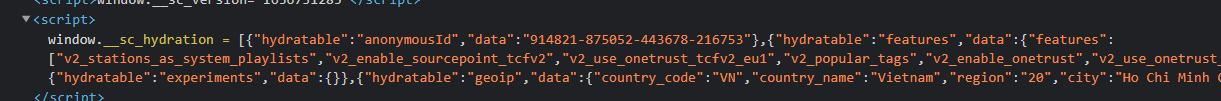

In [ ]:
def crawl_user_data(url, driver, additional=False):
    '''Return User dictionary, list of user's track, playlist urls and user's following'''
    track_url, user_url, playlist_url = [], [], []
    driver.get(url)
    script = driver.execute_script('return window.__sc_hydration')
    user_features = script[-1].get('data')
    user = {'UserID': str(user_features.get('id')), 'username': user_features.get('username'), 'permalink_url': user_features['permalink_url'],'followers_count': user_features['followers_count'], 
            'Playlist count': user_features['playlist_count'], 'track count': user_features['track_count']}

    if(additional):
        scroll_webpage(driver, SCROLL_PAUSE_TIME=1)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        tails = soup.findAll('a', class_='soundTitle__title')
        for tail in tails:
            try:
                if 'sets' in tail['href']:
                    playlist_url.append('https://soundcloud.com' + tail['href'])
                else:
                    track_url.append('https://soundcloud.com' + tail['href'])
            except:
                break

        driver.get(url+'/following')
        scroll_webpage(driver)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        try:
            following = soup.findAll('a', class_='userBadgeListItem__heading')
            for item in following:
                user_url.append('https://soundcloud.com' + item['href'])
        except:
            pass
        return user, track_url, playlist_url, user_url

    return user
    

# *Crawling data*
### Khởi động driver

In [ ]:
driver = webdriver.Chrome('chromedriver.exe')
driver.get('https://soundcloud.com')
driver.find_element_by_id('onetrust-accept-btn-handler').click() #Accept call cookies

### Khởi tạo các list 
 - Các list playlists, tracks, users dùng để chứa các dictionary mang thông tin của từng mỗi loại
 - Các list playlist_url, track_url, users_url dùng để chứa các đường link để cho vào hàm crawl dữ liệu


In [ ]:
playlists, tracks, users = [], [], []
playlist_url, track_url, users_url = [], [], []

### Load Data (Nếu đã có sẵn các link để crawl)
Load những links đã có sẵn.

### Get những đường link playlist từ trang discover (Nếu chưa có sẵn đường link)

In [ ]:
playlist_url = Crawl_data_from_discover(driver)

## Crawl playlist data
- Từ những đường link playlist get được ở trên, chúng ta sẽ sử dụng hàm để crawl thông tin playlist và các đường link khác của users và track bên trong.
- Ta sẽ lần lượt pop các phần tử trong list playlist_url để append vào vào list các dict của playlist đồng thời thu thập thêm url của track và user ở bên trong.
- Sử dụng pop để khi push những playlist mới vào list sẽ không bị trùng lắp duyệt nhiều lần

In [ ]:
for _ in range(len(playlist_url)):
    try:
        playlist_temp, track_temp, user_temp = crawl_playlist_data(playlist_url.pop(), driver)
        playlists.append(playlist_temp)
        track_url += track_temp
        users_url += user_temp
    except:
        pass

### Lưu thông tin của playlist vào một file csv

In [ ]:
pd.DataFrame.from_dict(playlists).to_csv('playlists.csv', sep='\t', index=False)

### Merge dữ liệu mới vào dữ liệu cũ đã thu thập và lọc các phần tử duplicate theo ID

In [ ]:
new_playlist = pd.DataFrame.from_dict(playlists)
old_playlist = pd.read_csv('playlists.csv', sep='\t')
out_playlist = old_playlist.append(new_playlist)
out_playlist.drop_duplicates(subset ="Playlist ID")
out_playlist.to_csv('playlists.csv', sep='\t', index=False)

In [10]:
pd.read_csv('playlists.csv', sep='\t')

,Playlist ID,Tilte,Playlist url,Genre,Likes count,Repost count,Track Count,TrackIDs,Creator ID,Creator name,user url
0,659700135,💔 sad songs to cry yourself to sleep to 💔,https://soundcloud.com/ultrasadly/sets/sad-son...,Ambient,3993,170.0,15,205830401 440259888 411375333 201493685 294339...,295090381,☹,https://soundcloud.com/ultrasadly
1,94099602,Calm Night Sky,https://soundcloud.com/mrteddy_us/sets/zen,chill,19234,2005.0,19,172821893 1044398359 184427657 161971413 15079...,69204911,MrTeddy,https://soundcloud.com/mrteddy_us
2,819362814,Best Electro of All-Time (Vol. 01),https://soundcloud.com/digitalstreams/sets/ele...,workout,17393,604.0,48,75151590 72447821 345370105 54740440 25730687 ...,133467077,Westcoast Radio (EDM),https://soundcloud.com/digitalstreams
3,110187832,Best of Trap & Bass,https://soundcloud.com/westcoastradiotv/sets/t...,trap,50289,2859.0,38,935544391 909356458 59527799 1070687083 102009...,139777650,Westcoast Radio,https://soundcloud.com/westcoastradiotv
4,223557686,YNM#4,https://soundcloud.com/teamdr/sets/noise-basement,Hip-hop & Rap,13197,860.0,40,166806576 154696577 18180609 227404021 1518904...,47788017,ARA,https://soundcloud.com/teamdr
...,...,...,...,...,...,...,...,...,...,...,...
3532,1346076781,GREY ZONE REDUX EP,https://soundcloud.com/hybridtrapradio/sets/gr...,NaN,2,1.0,4,1101079417 1101080818 1101081295 1103165299,162054074,Hybrid Trap Radio,https://soundcloud.com/hybridtrapradio
3533,1034027632,Only the Gods / Better on My Own (feat. Anabel...,https://soundcloud.com/disciplesldn/sets/only-...,Dance,67,11.0,2,783820024 783303184,52306541,DisciplesLDN,https://soundcloud.com/disciplesldn
3534,2303042,Gent & Jawns - Holler (JEFF026),https://soundcloud.com/maddecent/sets/gent-jaw...,Moombahton/Tropical Bass,55,3.0,4,54887550 54887551 54887553 54893756,14730,Mad Decent,https://soundcloud.com/maddecent
3535,1228784812,drip-133 & tulsi - heaven spot [album],https://soundcloud.com/drip-133/sets/drip-133-...,selective,325,72.0,7,1010976283 1010976274 1010976262 1010976250 10...,27218273,drip-133,https://soundcloud.com/drip-133


## Crawl user data
- Từ những đường link get được ở bước trên ta sẽ tiếp tục crawl tiếp data về user trong list users_url
- Trường hợp nếu biến **additional = True**, thì chúng ta sẽ tiếp tục thêm các url của track, playlist vào cái list tương ứng, và sẽ có thêm một list user mới từ những người mà user đó đang follow.

In [ ]:
for _ in range(len(users_url)):
    try:
        user_temp = crawl_user_data(users_url.pop(), driver)
        users.append(user_temp)
    except:
        pass

### Lưu thông tin của users vào một file csv

In [ ]:
pd.DataFrame.from_dict(users).to_csv('users.csv', sep='\t', index=False)

### Merge dữ liệu mới vào dữ liệu cũ đã thu thập và lọc các phần tử duplicate theo ID

In [ ]:
new_user = pd.DataFrame.from_dict(users)
old_user = pd.read_csv('users.csv', sep='\t')
out_user = old_user.append(new_user)
out_user.drop_duplicates(subset ="UserID")
out_user.to_csv('users.csv', sep='\t', index=False)

In [11]:
pd.read_csv('users.csv', sep='\t')

,UserID,username,permalink_url,followers_count,Playlist count,track count
0,68064562,Phillip Lee Eyer,https://soundcloud.com/phillip-lee-eyer,365,2,33
1,164048,brooklynvegan,https://soundcloud.com/brooklynvegan,11052,89,768
2,1698611,Dan Griffin,https://soundcloud.com/dangriffin,821,5,25
3,36503208,cvnuvbis,https://soundcloud.com/cvnuvbis,445,2,21
4,25262269,KIDS OF ADELAIDE,https://soundcloud.com/kidsofadelaide,475,0,2
...,...,...,...,...,...,...
5162,193879734,Bella Ruby,https://soundcloud.com/bellarubyy,5838,0,28
5163,285775117,ultravloiance,https://soundcloud.com/frarylaide,13,0,2
5164,221047350,deadbeatteen,https://soundcloud.com/deadbeatteen,3477,0,37
5165,256055700,1800entity,https://soundcloud.com/1800entity,1931,8,35


## Crawl track data
Crawl data của track từ list các đường link của track.

In [ ]:
for _ in range(len(track_url)):
    try:
        track_temp = crawl_track_data(track_url.pop(), driver)
        tracks.append(track_temp)
    except:
        continue

### Lưu thông tin của users vào một file csv

In [ ]:
pd.DataFrame.from_dict(tracks).to_csv('tracks.csv', sep='\t', index=False)

### Merge dữ liệu mới vào dữ liệu cũ đã thu thập và lọc các phần tử duplicate theo ID

In [ ]:
new_tracks = pd.DataFrame.from_dict(tracks)
old_tracks = pd.read_csv('tracks.csv', sep='\t')
out_tracks = old_tracks.append(new_tracks)
out_tracks.to_csv('tracks.csv', sep='\t', index=False)

In [12]:
pd.read_csv('tracks.csv', sep='\t')

,Track ID,Title,Genre,Track url,Created at,Likes count,Reposts count,playback_count,Creator,Creator ID,Creator url
0,61006162,Marcus Foster - Worn Down By Time,NaN,https://soundcloud.com/unofficialsxsw/marcus-f...,2012-09-24T17:00:36Z,10142.0,268,1129789.0,Unofficial SXSW Guide,3231763,https://soundcloud.com/unofficialsxsw
1,142856772,OLD ONE,Indie,https://soundcloud.com/kidsofadelaide/old-one-...,2014-04-03T12:55:05Z,4387.0,180,465435.0,KIDS OF ADELAIDE,25262269,https://soundcloud.com/kidsofadelaide
2,175674014,Making All Things New (Waterman/Espe) - Record...,indie rock,https://soundcloud.com/dougwaterman/making-all...,2014-11-06T19:43:33Z,115693.0,3026,5399261.0,dougwaterman,1381451,https://soundcloud.com/dougwaterman
3,191782697,THESE BRITTLE BONES - FLECKS (CVNИVBI$ REMAKE),Indie,https://soundcloud.com/cvnuvbis/these-brittle-...,2015-02-18T17:01:24Z,6334.0,207,682278.0,cvnuvbis,36503208,https://soundcloud.com/cvnuvbis
4,193748194,Sweet Love,Phillip Lee Eyer,https://soundcloud.com/phillip-lee-eyer/sweet-...,2015-03-01T23:55:26Z,9858.0,256,1008527.0,Phillip Lee Eyer,68064562,https://soundcloud.com/phillip-lee-eyer
...,...,...,...,...,...,...,...,...,...,...,...
20581,411375333,i named the black hole in my chest andrew jack...,ambiemo,https://soundcloud.com/bedhead2001/andrew-jack...,2018-03-10T01:03:33Z,NaN,0,NaN,bedhead,363279257,https://soundcloud.com/bedhead2001
20582,314265809,Valley of the Dead,NaN,https://soundcloud.com/nicoledollanganger/vall...,2017-03-24T15:40:07Z,627.0,18,42124.0,Nicole Dollanganger,7110587,https://soundcloud.com/nicoledollanganger
20583,205830401,unless im wrong,SESH,https://soundcloud.com/drip-133/unless-im-wron...,2015-05-17T01:59:03Z,15034.0,2209,981233.0,drip-133,27218273,https://soundcloud.com/drip-133
20584,160180518,surrenderdorothy - whatcouldpossiblygowrong,surrenderdorothy,https://soundcloud.com/surrenderdorothymusic/s...,2014-07-25T02:09:09Z,27621.0,3134,1849326.0,surrenderdorothy,90216387,https://soundcloud.com/surrenderdorothymusic
